In [3]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [4]:
import numpy as np
import pandas as pd

In [5]:
import datetime as dt

## Reflect Tables into SQLAlchemy ORM

In [6]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [7]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [8]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [9]:
# view all of the classes that automap found
# Base.classes.keys() 
inspector=inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [10]:
# Save references to each table
Measurement=Base.classes.measurement
Station=Base.classes.station

In [11]:
# Create our session (link) from Python to the DB
session=Session(engine)

## Exploratory Climate Analysis

In [12]:
# Display rows columns and data in dictionary format
# first_row=session.query(Measurement).first()
# first_row.__dict__

# List column names and types for measurement table
columns=inspector.get_columns('measurement')
for c in columns:
    print(c["name"], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


## Precipitation Analysis

In [13]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
#Calculate the date 1 year ago from the last data point in the database 
# Last Date
last_date=session.query(Measurement.date).order_by(Measurement.date.desc()).first()
print(last_date)

('2017-08-23',)


In [14]:
prior_year=dt.date(2017,8,23) - dt.timedelta(days=365)
prior_year

datetime.date(2016, 8, 23)

In [15]:
# Perform a query to retrieve the data and precipitation scores
query_last=session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date > prior_year).all()
query_last

# Save query to Pandas DF
df=pd.DataFrame(query_last,columns=['date', 'prcp'])
df.set_index('date')

# Sort dataframe by date
df=df.sort_values('date')
df.head(10)

,date,prcp
0,2016-08-24,0.08
1006,2016-08-24,NaN
1524,2016-08-24,2.15
702,2016-08-24,2.28
360,2016-08-24,2.15
1875,2016-08-24,1.45
1188,2016-08-24,1.22
1,2016-08-25,0.08
1007,2016-08-25,0.00
1525,2016-08-25,0.06


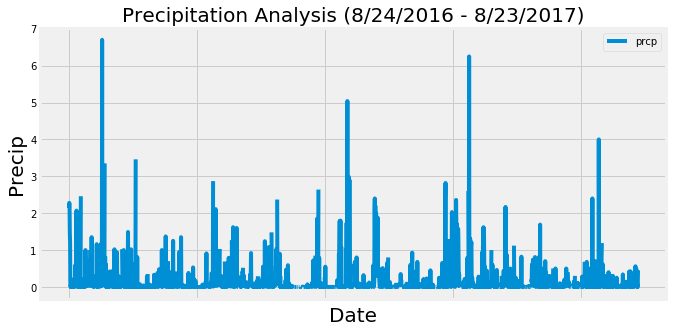

In [37]:
# Use Pandas Plotting with Matplotlib to plot
df.plot(x='date', y='prcp', figsize=(10,5))
plt.xticks(rotation=90)
plt.xlabel("Date", size=20)
plt.ylabel('Precip', size=20)
plt.title('Precipitation Analysis (8/24/2016 - 8/23/2017)', size=20)
plt.show()

In [17]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df.describe()

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


## Station Analysis

In [18]:
# Design a query to show how many stations are available in this dataset?
#try .format: Syntax : { } .format(value)
stations=session.query(Measurement).group_by(Measurement.station).count()
print("There are {} stations in this dataset.".format(stations))

There are 9 stations in this dataset.


In [19]:
# measurement counts
session.query(Measurement.station).count()

19550

In [20]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
station_count=session.query(Measurement.station, func.count(Measurement.station)).\
group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()
station_count

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

#### Lowest temp, highest temp, average temp for station USC00519281

In [21]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
low_high_avg=session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
filter(Measurement.station=='USC00519281').all()
print(f"The lowest temp, highest temp, and average temp for Station USC00519281 is listed below:")
print(low_high_avg)

The lowest temp, highest temp, and average temp for Station USC00519281 is listed below:
[(54.0, 85.0, 71.66378066378067)]


In [22]:
# how to get the values above out of the list to show in as a df?

In [23]:
# Show column headers for Measurement Table
first_row=session.query(Measurement).first()
# first_row.__dict__

In [24]:
# # Show column headers for Station Table
first_row=session.query(Station).first()
# first_row.__dict__

In [25]:
# Query the last 12 months of temperature observation data for this station 
# and plot the results as a histogram
#station USC00519281 has highest number of observations. 
obs=session.query(Measurement.tobs).filter(Measurement.station=='USC00519281').\
filter(Measurement.date>=prior_year).order_by(Measurement.date.desc()).all()
obs_df=pd.DataFrame(obs)
obs_df.head(5)

,tobs
0,79.0
1,76.0
2,76.0
3,77.0
4,77.0


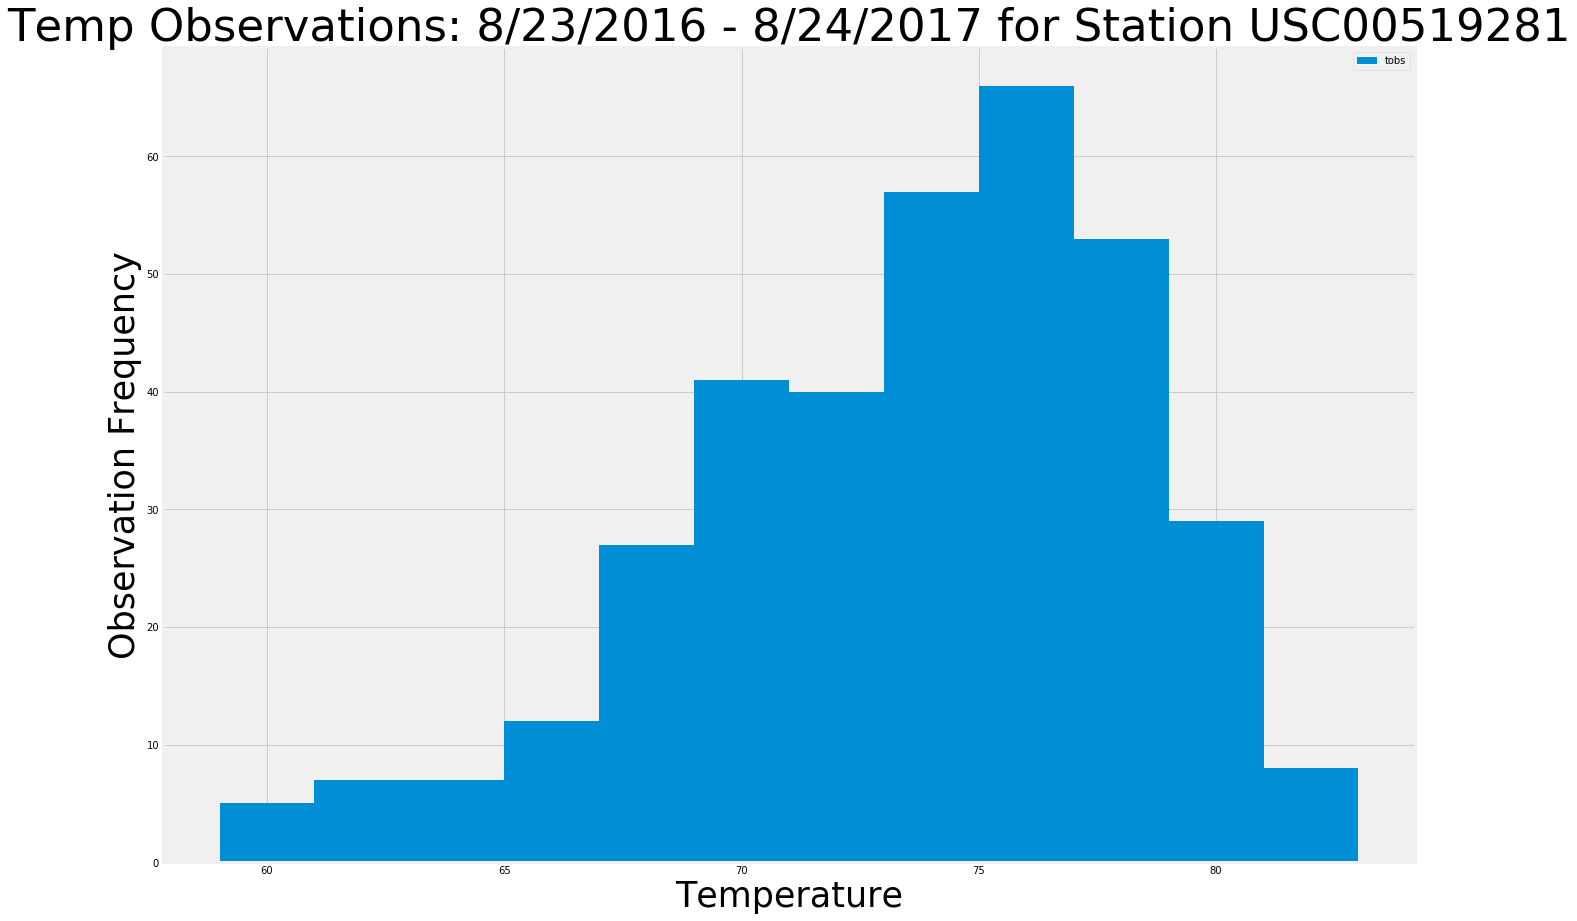

In [38]:
# Histogram
obs_df.plot(kind='hist', figsize=(20,15), bins=12)
plt.title("Temp Observations: 8/23/2016 - 8/24/2017 for Station USC00519281", size=45)
plt.xlabel("Temperature", size=35)
plt.ylabel('Observation Frequency', size=35)
plt.show()

## Bonus Challenge Assignment

In [27]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [28]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [29]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [30]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [31]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [32]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [33]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [34]:
# Plot the daily normals as an area plot with `stacked=False`
